In [3]:
import os
import sys
from optparse import OptionParser

import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

%matplotlib inline 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables 
import pickle
import warnings
from sklearn.externals import joblib
warnings.filterwarnings('once')

In [4]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/opt-4-'

# Small IT Ineff Region

In [59]:
# ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model.txt')
def ineff_model(dist,E): # E: log10 of energy!!! 

    a = params[0] + params[2] * (E + params[1])**2
    b = params[3] + params[5] * (E + params[4])**2
    val = 10 * a / dist**(1/3.) * np.exp( -10**6 * b / dist**2)
    
    val[val < 0.001] = 0.001 # This is arbitrary! 

    # low stat cut 
#     val[E > 5.4+1.9*np.sqrt(1 - (dist)**2/2300**2)]=0.7
    val[(E-5.4)**2/1.9**2 > 1 - (dist)**2/2300**2] = 0.7
    val[dist>2200]=0.7
    return val

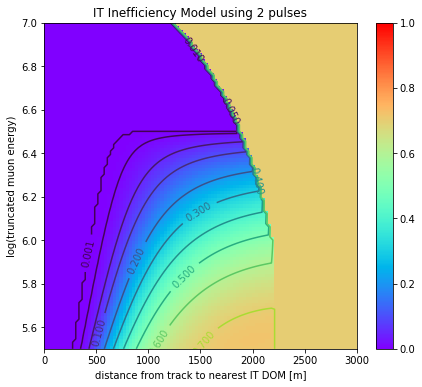

In [60]:
xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model(xg,yg)

plt.figure(figsize=(7,6))
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance from track to nearest IT DOM [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('IT Inefficiency Model using 2 pulses')
plt.savefig(fig_dir + 'IT_ineff_model.png',dpi=300,bbox_inches='tight')
plt.show()

In [262]:
IT_ineff_cut = 0.01

p1 = 5.52 # y center
p2 = 1.2
p3 = 1.1 # x center
p4 = 0.4

chi2_cut = 0.3
pom_cut = 0.8

# corsika
# with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11937.h5','r') as f:
#     n_file = 100000 # with _rf, the size of broken file is 266K instead of 0! 
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file = 74909 # with _rf, the size of broken file is 266K instead of 0! 
    ineff_corsika = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_corsika < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    CUT_phase = (np.cos(f.root.SplineMPE.cols.zenith[:])-p3)**2/p4**2+\
                (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])-p1)**2/p2**2 > 0
    CUT_stoch = (f.root.Collection.cols.chi2_red[:]>chi2_cut) & (np.log10(f.root.Collection.cols.PeakOverMedian[:])>pom_cut)
    
    CUT = CUT_ineff & CUT_dedx & CUT_stoch
    
    chi2_red_corsika = f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_corsika = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    b_size_corsika = f.root.Bundle.cols.Size[:][CUT]
    casllh_corsika = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    
    weight_corsika = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file # * 903098/363528
    print(np.sum(f.root.Weight_GaisserH4a.cols.value[:])* lifetime/n_file)
    print('corsika',np.sum(weight_corsika))
    
# numu 
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 19999

    ineff_numu = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_numu < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    CUT_phase = (np.cos(f.root.SplineMPE.cols.zenith[:])-p3)**2/p4**2+\
            (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])-p1)**2/p2**2 > 0
    CUT_stoch = (f.root.Collection.cols.chi2_red[:]>chi2_cut) & (np.log10(f.root.Collection.cols.PeakOverMedian[:])>pom_cut)
    
    CUT = CUT_ineff & CUT_dedx & CUT_stoch
    
    chi2_red_numu = f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_numu = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    casllh_numu = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]

    ### astrophysical ###
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

    weight_numu_conv = f.root.Weight_honda2006_gaisserH4a_elbert.cols.value[:][CUT] * lifetime/n_file 
    weight_numu_prompt = f.root.Weight_BERSS_H3p_central.cols.value[:][CUT] * lifetime/n_file 
    
    print('astro numu',np.sum(weight_numu_astro))
    print('conv numu',np.sum(weight_numu_conv))
    print('prompt numu',np.sum(weight_numu_prompt))

# nue
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11981.h5','r') as f:
    n_file = 19972

    ineff_nue = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_nue < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    CUT_phase = (np.cos(f.root.SplineMPE.cols.zenith[:])-p3)**2/p4**2+\
            (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])-p1)**2/p2**2 > 0
    CUT_stoch = (f.root.Collection.cols.chi2_red[:]>chi2_cut) & (np.log10(f.root.Collection.cols.PeakOverMedian[:])>pom_cut)
    
    CUT = CUT_ineff & CUT_dedx & CUT_stoch

    chi2_red_nue = f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_nue = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_nue = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_nue = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]

    ### astrophysical ###
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_nue_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

    weight_nue_conv = f.root.Weight_honda2006_gaisserH4a_elbert.cols.value[:][CUT] * lifetime/n_file 
    weight_nue_prompt = f.root.Weight_BERSS_H3p_central.cols.value[:][CUT] * lifetime/n_file 

    print('astro nue',np.sum(weight_nue_astro))
    print('conv nue',np.sum(weight_nue_conv))
    print('prompt nue',np.sum(weight_nue_prompt))
    
# nutau
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11477.h5','r') as f:
    n_file = 19970

    ineff_nutau = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_nutau < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    CUT_phase = (np.cos(f.root.SplineMPE.cols.zenith[:])-p3)**2/p4**2+\
            (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])-p1)**2/p2**2 > 0
    CUT_stoch = (f.root.Collection.cols.chi2_red[:]>chi2_cut) & (np.log10(f.root.Collection.cols.PeakOverMedian[:])>pom_cut)
    
    CUT = CUT_ineff & CUT_dedx & CUT_stoch

    chi2_red_nutau = f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_nutau = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_nutau = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_nutau = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]

    ### astrophysical ###
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_nutau_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

    print('astro nutau',np.sum(weight_nutau_astro))

# burn sample
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3110722.657,3155703.188,3082765.564]
    
    ineff_data_burn = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_data_burn < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    CUT_phase = (np.cos(f.root.SplineMPE.cols.zenith[:])-p3)**2/p4**2+\
            (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])-p1)**2/p2**2 > 0
    CUT_stoch = (f.root.Collection.cols.chi2_red[:]>chi2_cut) & (np.log10(f.root.Collection.cols.PeakOverMedian[:])>pom_cut)
    CUT_IT = (f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool) 
    
    CUT = CUT_ineff & CUT_dedx & CUT_stoch & CUT_IT
    
    chi2_red_data_burn = f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    casllh_data_burn = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]

    passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 

    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))
    
    run_id_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    event_id_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]
    
    print('burn sample',np.sum(weight_data_burn))
    

527175.8140768568
corsika 1904.6092011371315
astro numu 0.4656145521453152
conv numu 0.004535409279220013
prompt numu 0.0020872194520211978
astro nue 0.048780452553743255
conv nue 0.00013488940100813622
prompt nue 6.161350857631353e-05
astro nutau 0.17117360677747925
burn sample 97.11093827138802


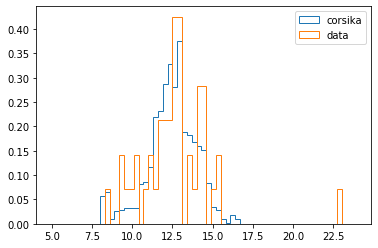

In [263]:
plt.hist(casllh_corsika,bins=np.arange(5,24,0.3),weights=weight_corsika,density=True,histtype='step',label='corsika')
plt.hist(casllh_data_burn,bins=np.arange(5,24,0.3),weights=weight_data_burn,density=True,histtype='step',label='data')
plt.legend()
plt.show()

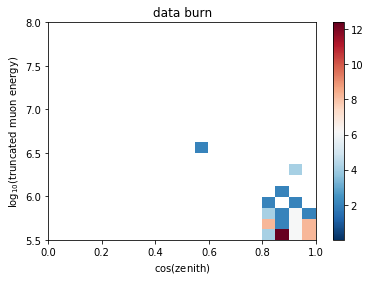

In [264]:
# ----- phase space ----- #
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

h_,yy_,xx_,img_ = plt.hist2d(np.cos(zenith_data_burn),np.log10(truncated_muon_e_data_burn),cmap=my_cmap,
            bins=20,range=[[0,1],[5.5,8]],weights=weight_data_burn,vmin = 0.001)
plt.colorbar()
plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(truncated muon energy)')
plt.title('data burn')

plt.savefig(fig_dir + 'hist2d_phase_spcae_each_stoch_region.png',dpi=300,bbox_inches='tight')
plt.show()

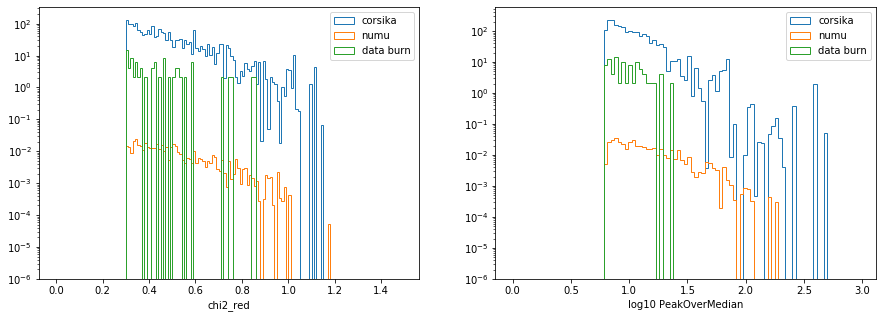

In [265]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(chi2_red_corsika,bins=np.arange(0,1.5,0.01),weights=weight_corsika,histtype='step',log=True,label='corsika',bottom=10**(-6))
plt.hist(chi2_red_numu,bins=np.arange(0,1.5,0.01),weights=weight_numu_astro,histtype='step',log=True,label='numu',bottom=10**(-6))
plt.hist(chi2_red_data_burn,bins=np.arange(0,1.5,0.01),weights=weight_data_burn,histtype='step',log=True,label='data burn',bottom=10**(-6))
# plt.axvline(chi2_red_cut,label=r'$\chi^2_{red}=$'+str(chi2_red_cut),color='b')
plt.legend(loc='upper right')
plt.xlabel('chi2_red')

plt.subplot(122)
plt.hist(np.log10(PeakOverMedian_corsika),bins=np.arange(0,3.0,0.03),weights=weight_corsika,histtype='step',log=True,label='corsika',bottom=10**(-6))
plt.hist(np.log10(PeakOverMedian_numu),bins=np.arange(0,3.0,0.03),weights=weight_numu_astro,histtype='step',log=True,label='numu',bottom=10**(-6))
plt.hist(np.log10(PeakOverMedian_data_burn),bins=np.arange(0,3.0,0.03),weights=weight_data_burn,histtype='step',log=True,label='data burn',bottom=10**(-6))
# plt.axvline(pom_cut,label=r'$logPeakOverMedian=$'+str(pom_cut),color='g')
plt.legend(loc='upper right')
plt.xlabel('log10 PeakOverMedian')

plt.savefig(fig_dir + 'hist1d_stochasticity.png',dpi=300,bbox_inches='tight')
plt.show()

# Energy spectrum with muon bg estimated from data

In [266]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3110722.657,3155703.188,3082765.564]
    
    ineff_data_burn = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_data_burn < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    CUT_stoch = (f.root.Collection.cols.chi2_red[:]>chi2_cut) & (np.log10(f.root.Collection.cols.PeakOverMedian[:])>pom_cut)
    CUT = CUT_ineff & CUT_dedx & CUT_stoch
    
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]

    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))
    print(np.sum(weight_data_burn))

2797.6214982863703


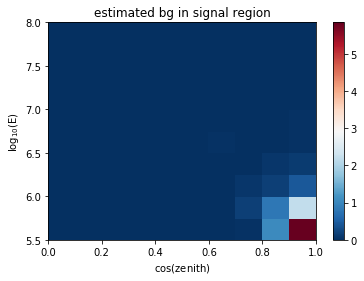

In [267]:
# estimated bg in signal region 

plt.figure()
pass_factor = 0.004336168420811881

# cut_bg = np.all([chi2_red_data_burn<chi2_cut,np.log10(PeakOverMedian_data_burn)<pom_cut])
# cut_sig = (chi2_red_data_burn>chi2_cut) & (np.log10(PeakOverMedian_data_burn)>pom_cut)

h_,xx_,yy_,img_=plt.hist2d(np.cos(zenith_data_burn),np.log10(truncated_muon_e_data_burn),cmap=my_cmap,
            bins=10,range=[[0,1],[5.5,8]],weights=weight_data_burn * pass_factor)
plt.colorbar()    
plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(E)')
plt.title('estimated bg in signal region')
plt.show()

In [268]:
est_bg=np.sum(h_,axis=0)
est_bg

array([6.95245451, 3.18056875, 0.69882919, 0.20606502, 0.10751218,
       0.05375609, 0.        , 0.        , 0.        , 0.        ])

In [269]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3110722.657,3155703.188,3082765.564]
    
    ineff_data_burn = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_data_burn < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    CUT_IT = (f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool)  # passed veto
    CUT_stoch = (f.root.Collection.cols.chi2_red[:]>chi2_cut) & (np.log10(f.root.Collection.cols.PeakOverMedian[:])>pom_cut)

    CUT = CUT_ineff & CUT_dedx & CUT_stoch & CUT_IT
    
    chi2_red_data_burn =f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]

    passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 

    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))
    print(np.sum(weight_data_burn))
    
    run_id_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    event_id_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]

97.11093827138802


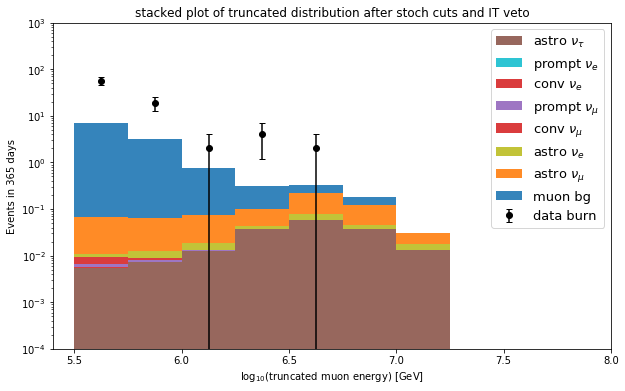

In [272]:
plt.figure(figsize=(10,6))

h,b = np.histogram(np.log10(truncated_muon_e_data_burn),weights=weight_data_burn,bins=np.linspace(5.5,8.,11))
b = (b[1:]+b[:-1])/2
plt.errorbar(b,h,yerr=np.sqrt(h*weight_data_burn[0]),capsize=3,fmt='o',color='black',label='data burn')

names = [r'astro $\nu_{\tau}$',
            r'prompt $\nu_{e}$',
            r'conv $\nu_{e}$',
            r'prompt $\nu_{\mu}$',
            r'conv $\nu_{\mu}$',
            r'astro $\nu_e$',
            r'astro $\nu_{\mu}$',
            'muon bg'
        ]
weighting = [weight_nutau_astro,
                weight_nue_prompt,
                weight_nue_conv,
                weight_numu_prompt,
                weight_numu_conv,
                weight_nue_astro,
                weight_numu_astro,
                est_bg
            ]
quantities = [np.log10(truncated_muon_e_nutau),
                np.log10(truncated_muon_e_nue),
                np.log10(truncated_muon_e_nue),
                np.log10(truncated_muon_e_numu),
                np.log10(truncated_muon_e_numu),
                np.log10(truncated_muon_e_nue),
                np.log10(truncated_muon_e_numu),
                b
             ]
colors = ['tab:brown','tab:cyan','tab:red','tab:purple','tab:red','tab:olive','tab:orange','tab:blue']


plt.hist(quantities,stacked=True,log=True,color=colors,alpha=0.9,weights=weighting,bins=np.linspace(5.5,8.,11),label=names)

plt.xlabel(r'$\log_{10}($truncated muon energy) [GeV]')
plt.ylabel('Events in 365 days')
plt.xlim(5.4,8)
plt.ylim(10**(-4),10**3)
plt.legend(prop={'size': 13})
plt.title('stacked plot of truncated distribution after stoch cuts and IT veto')

plt.show()

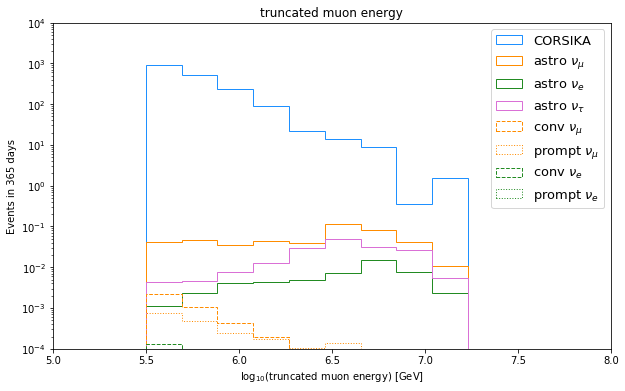

In [271]:
plt.figure(figsize=(10,6))
plt.hist(np.log10(truncated_muon_e_corsika),bins=np.linspace(5.5,8.,14),log=True,histtype='step',lw=1,label='CORSIKA',weights=weight_corsika,bottom=10**(-6),color='dodgerblue')

plt.hist(np.log10(truncated_muon_e_numu),bins=np.linspace(5.5,8.,14),log=True,histtype='step',lw=1,label=r'astro $\nu_{\mu}$',weights=weight_numu_astro,bottom=10**(-6),color='darkorange')
plt.hist(np.log10(truncated_muon_e_nue),bins=np.linspace(5.5,8.,14),log=True,histtype='step',lw=1,label=r'astro $\nu_e$',weights=weight_nue_astro,bottom=10**(-6),color='forestgreen')
plt.hist(np.log10(truncated_muon_e_nutau),bins=np.linspace(5.5,8.,14),log=True,histtype='step',lw=1,label=r'astro $\nu_{\tau}$',weights=weight_nutau_astro,bottom=10**(-6),color='orchid')

plt.hist(np.log10(truncated_muon_e_numu),bins=np.linspace(5.5,8.,14),log=True,histtype='step',lw=1,linestyle='--',label=r'conv $\nu_{\mu}$',weights=weight_numu_conv,bottom=10**(-6),color='darkorange')
plt.hist(np.log10(truncated_muon_e_numu),bins=np.linspace(5.5,8.,14),log=True,histtype='step',lw=1,linestyle=':',label=r'prompt $\nu_{\mu}$',weights=weight_numu_prompt,bottom=10**(-6),color='darkorange')
plt.hist(np.log10(truncated_muon_e_nue),bins=np.linspace(5.5,8.,14),log=True,histtype='step',lw=1,linestyle='--',label=r'conv $\nu_{e}$',weights=weight_nue_conv,bottom=10**(-6),color='forestgreen')
plt.hist(np.log10(truncated_muon_e_nue),bins=np.linspace(5.5,8.,14),log=True,histtype='step',lw=1,linestyle=':',label=r'prompt $\nu_{e}$',weights=weight_nue_prompt,bottom=10**(-6),color='forestgreen')

plt.xlabel(r'$\log_{10}($truncated muon energy) [GeV]')
plt.ylabel('Events in 365 days')
plt.xlim(5,8)
plt.ylim(10**(-4),10**4)
plt.legend(prop={'size': 13})
plt.title('truncated muon energy')

plt.show()

# Systematics: 